# Part 1. Simple housing model

Your task is to implement a simple model to predict home prices for a small  transactions dataset.

Instructions
Download the sample dataset here.
Predict the close price as of list date given the other attributes.
Build separate models with and without ListPrice.
Feel free to join the dataset to any other data sources, so long as they are not leaky.

Questions
Describe your methodology. Why did you pick it?
How well would you do if you excluded the list price?
What is the performance of your model? What error metrics did you choose?
How would you improve your model?
How would you host your model in a production environment to predict values of homes in real-time?

## Load Libraries

In [340]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import statistics as stat

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing  # or one-hot-outlier
#from sklearn.metrics import classification_report
#from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
#                             f1_score)
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [341]:
## Load Data Set
df = pd.read_csv('data_sci_snippet.csv')  # , header=0
#df.head(3)

## Preprocessing

In [342]:
## Conver Dates: str to Datetime
df['ListDate'] = pd.to_datetime(df['ListDate'])
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
## Convert Dates: datetime to ordinals
df['CloseDateInt'] = df['CloseDate'].apply(lambda x: x.toordinal())
df['ListDateInt'] = df['ListDate'].apply(lambda x: x.toordinal())

##Add TimeToClose  # As time to close -> oo, ClosePrice decreases
df['TimeToClose'] = df['CloseDateInt'] - df['ListDateInt']

In [343]:
## Convert Categorical vectors to dummy (1-hot encoded) binary vectors 

def gen_dummies(dfColumn,columnName):
    data = pd.DataFrame({columnName: dfColumn})
    res = pd.get_dummies(data)
    return res

# Generate Dummy Vectors
poolDummies = gen_dummies(df['Pool'], 'Pool')  #list(df.columns.values)[4]
dwellingTypeDummies = gen_dummies(df['DwellingType'], 'DwellingType')  #list(df.columns.values)[14]

# Concatenate with df
df = pd.concat([df, poolDummies], axis=1, join_axes=[df.index])
df = pd.concat([df, dwellingTypeDummies], axis=1, join_axes=[df.index])
df.head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,Pool_None,Pool_Private,DwellingType_Apartment Style/Flat,DwellingType_Gemini/Twin Home,DwellingType_Loft Style,DwellingType_Mfg/Mobile Housing,DwellingType_Modular/Pre-Fab,DwellingType_Patio Home,DwellingType_Single Family - Detached,DwellingType_Townhouse
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,...,0,1,0,0,0,0,0,0,1,0
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,1,0,0,0,0,0,0,1,0
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,...,0,1,0,0,0,0,0,0,1,0


In [344]:
## Convert Categorical Data to a 'hot-encoding'
# Note that the magnitude that will be assessed is based on the coder's 
# belief in the relative utility of the option.
# Sould be sorted on average cost of each option

# First 'Pool' Data Set (0-3 Hot-encoding)
lePool = preprocessing.LabelEncoder()
#lePool.fit(df['Pool'])
lePool.classes_ = ['None', 
                   'Community',
                   'Private', 
                   'Both Private & Community'] # Question this assumption!
#list(lePool.classes_)
df['Pool'] = lePool.transform(df['Pool'])

In [345]:
# Second DwellingType (0-7 Hot-encoding)
leDT = preprocessing.LabelEncoder()
#leDT.fit(df['DwellingType'])
#list(leDT.classes_)
leDT.classes_ = ['Modular/Pre-Fab',
                 'Mfg/Mobile Housing',
                 'Gemini/Twin Home',
                 'Apartment Style/Flat',
                 'Loft Style',
                 'Townhouse',
                 'Patio Home',
                 'Single Family - Detached']
#list(leDT.classes_)
#list(lePool.classes_)
df['DwellingType'] = leDT.transform(df['DwellingType'])

In [346]:
## Clean Dataset for learning on ClosePrice
# Exclude Null ClosePrice Data, because it doesn't inform the ML algo
df = df[df.ClosePrice.notnull()]

In [347]:
## Living Area: If None, replace with median value 
df.LivingArea[df.LivingArea.isnull()] = stat.median(df['LivingArea'])
#df[df['ListingId'] == 5140687]  # Confirm NaN replaced with median
#df[df.LivingArea.isnull()]

In [348]:
##GeoLat And GeoLon  # Bad Assumption, might get location from 'PublicRemarks'
df.GeoLat[df.GeoLat.isnull()] = stat.median(df['GeoLat'])
df.GeoLon[df.GeoLon.isnull()] = stat.median(df['GeoLon'])
#df.dtypes[df.dtypes.map(lambda x: x=='object')]

In [349]:
## Generate Training and Test Data Set (X , y)
# Training Variables , 'Pool', 'DwellingType'
X = df.drop(['ListDate', 'PublicRemarks', 'CloseDate', 'ClosePrice','ListingStatus'], axis=1) 
X.shape
#X.describe()

(37934, 25)

In [350]:
# Prediction Variable == Close Price 
y = df['ClosePrice']
y.shape

(37934,)

In [356]:
## Debug Tools
#df.head(3)
#df['DwellingType'].head(20)
#df.describe()
#df.dtypes
#df.shape  #[1]
#df['LivingArea'] = df['LivingArea'].astype('float32')
#df['sdfas'].gsub('%','')
df.summary

AttributeError: 'DataFrame' object has no attribute 'summary'

## Regression Model: Random Forest

In [351]:
## Test and Training Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33,
                                                    random_state=0)

In [352]:
## Train Random Forest
rgr = RandomForestRegressor(n_jobs=-1, 
                            max_features=None, 
                            n_estimators=100, 
                            oob_score=True, 
                            random_state=0)
y_pred = rgr.fit(X_train,y_train).predict(X_test)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


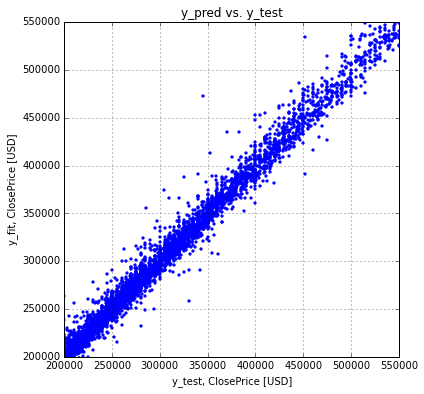

In [353]:
## Plot Resulting Prediction vs. Test
plt.figure(figsize=(6,6))

plt.scatter(y_test, y_pred, color='blue', s=5, edgecolor='none')
plt.xlim(200000,550000)
plt.ylim(200000,550000)
plt.grid(True)
plt.ylabel('y_fit, ClosePrice [USD]')
plt.xlabel('y_test, ClosePrice [USD]')
plt.title('y_pred vs. y_test')
plt.axes().set_aspect('equal') # 'datalim'
plt.show()

## Performance of Regression(s)

In [354]:
## Error Measurement: Variance between Prediction and Actual ClosePrice
mean_squared_error(y_test, y_pred)

418439188.13411808

### Improvements to Model are reductions in Mean-Squared-Error
Old version(s) of regressor had:
    mse = 466,666,896 -- Drop Pool and Dwelling type
    mse = 387,077,490 -- Hot-encoded Category Data

New version of regressor is:
    mse = 418,439,188 -- Hot-encoded category data and dummy vectors  <<= WTF! Why did it go up with more vectors?

In [307]:
df.drop(['Pool_None','Pool_Private'], axis=1)
df
#Z = pd.concat([X, y], axis=1)
#Z.shape

AttributeError: 'dict' object has no attribute 'drop'

In [249]:
## Evaluate PCA to Determine Pricipal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=25)  # Number of compenent vectors in the training set
pca.fit(X)
PCA(copy=True, n_components=25, whiten=False)
#print(pca.explained_variance_ratio_) 
# Note: first two contain 98% of the variance

[  9.34038846e-01   5.26015140e-02   1.33594905e-02   1.48127038e-07
   6.73811605e-10   3.72595571e-10   6.53832174e-11   3.14521300e-11
   1.37770583e-11   1.00489144e-11   6.72920505e-12   2.28625957e-12
   1.93328432e-12   1.28884057e-12   9.87168834e-13   5.09643877e-13
   4.82952078e-13   3.05699829e-13   2.20897240e-13   1.75237074e-14
   9.78388812e-15   7.13161849e-16   1.17974036e-33   1.43830480e-41
   5.11178215e-42]


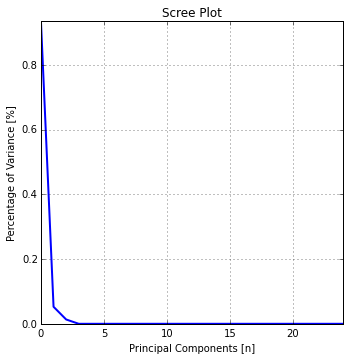

In [252]:
## Plot the PCA spectrum
plt.figure(figsize=(6, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2) # pca.explained_variance_
plt.axis('tight')
plt.grid(True)
plt.title('Scree Plot')
plt.xlabel('Principal Components [n]')
plt.ylabel('Percentage of Variance [%]') # for each eigenvector

## Questions

1) Q: Describe your methodology. Why did you pick it?
   
   A: Given Categorical and ordinal data I thought is best to approach this problem with a random forest. R would love this data set, but scikit-learn doesn't like categorical data. So this assumption should be tested against an SVM or beasian learning algorithm.

2) Q: How well would you do if you excluded the list price?
   
   A: Very Poorly! The ListPrice appears to contain the
   most information about the ClosePrice, as you would suspect.
   (Note: Drop the ListPrice column from the df to verify.)
   	  mse =   403,957,278 with ListPrice
   	  mse = 5,967,842,324 without ListPrice

3) What is the performance of your model? What error metrics did you choose?
   
   Mean-squared-error seems appropriate as we are predicting a regression, by comparing actual (I call this 'test' in my code) ClosePrice to the fitted ClosePrice. Changes made to the model should reduce the mean-squared-error.

4) Q: How would you improve your model?
	
   A: (1) binarize the categorical data. 
	  (2) Add a 'Time-to-Close' column, CloseDate - ListDate (implemented)
	  (3) Use the nltk to review 'PublicRemarks'
          Nouns should indicate special attributes
    	  i.e. 'work shed' or 'garage'.
    	  These are probably second-order effects

5) How would you host your model in a production environment to predict values of homes in real-time?
   
   A: If by real-time you are looking for the value of each option as the customer enters their home information. We would need to run a batch of combinations that constitute a dictionary that is called in real-time to establish the value of the home. In this way the algorithm could calculate home value combinations weekly or monthly and home valuations for the customer would be nearly instantaneous. This would work well for a model with a small number of combinations.

   If the combinations got astronomically large, many attributes in this data set are float, then the fastest way serve ClosePrice would be to run the algorithm live after the customer submits their home information. My algotithm runs at the speed of Zillow's query speed, so I would choose to train randomforest in advance and calculate the predicted ClosePrice live.

## What is Next?

After model is finalized, test on whole dataset.

Try GBM (Gradient Boosted Machines) next and GLM (Generalized Linear Model). GBM Normally beats deep learning and GLM. Mean-squared-error to compare regression models  
Apply a meta-learner specifically a GLM (nnps) to stack/ensemble the algorithms.

### Missing data:  
Source: http://artsci.wustl.edu/~gradconf/conf2015/Papers2015/1_3_Ho.pdf  
Baths  
Age of home  
% of neighbors with bachelors  
% of neighbors with mastors/adv. degree  
quality of neighborhood schools  
fireplace  

### Requested features:
early stopping
k-fold cross-validation

# Part 2. Simple n-grams

Generate the top 10 3-grams for the article http://en.wikipedia.org/wiki/N-gram


In [45]:
import urllib
from bs4 import BeautifulSoup
import nltk
#from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import *
import string

url = 'https://en.wikipedia.org/wiki/N-gram'
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html)

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)

#textFiltered = filter(None,[word.strip(string.punctuation)
#                 for word in text.replace(';','; ').split()
#                 ])

tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(text)

finder = TrigramCollocationFinder.from_words(tokens)
trigram_measures = nltk.collocations.TrigramAssocMeasures()
scored = finder.score_ngrams(trigram_measures.raw_freq)
sorted(finder.nbest(trigram_measures.raw_freq, 10))  # Return 10 trigrams

[('Syntactic', 'n', 'grams'),
 ('an', 'n', 'gram'),
 ('gram', 'models', 'are'),
 ('n', 'gram', 'is'),
 ('n', 'gram', 'model'),
 ('n', 'gram', 'models'),
 ('n', 'grams', 'for'),
 ('of', 'n', 'grams'),
 ('of', 'vocabulary', 'words'),
 ('serve', 'as', 'the')]

In [100]:
# Potentially superior implementation to allow for hypenated grams,
# down-side is Ellipsis dominate grams

import urllib
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
#from nltk.tokenize import RegexpTokenizer
from nltk.collocations import *
import string

url = 'https://en.wikipedia.org/wiki/N-gram'
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html)

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)
#text = str(filter(lambda x: x!=Ellipsis, text))
#text = text.replace('...','')

tokens = filter(None,[word.strip(string.punctuation)
                 for word in text.replace(';','; ').split()
                 ])

#tokens = nltk.wordpunct_tokenize(text)
#tokens = word_tokenize(text)


finder = TrigramCollocationFinder.from_words(tokens)
trigram_measures = nltk.collocations.TrigramAssocMeasures()
scored = finder.score_ngrams(trigram_measures.raw_freq)
sorted(finder.nbest(trigram_measures.raw_freq, 10))  # Return 10 trigrams

#Sources: 
#http://web.mit.edu/6.863/spring2010/python/nltk/test/collocations.doctest

[('also', 'be', 'used'),
 ('an', 'n-gram', 'model'),
 ('be', '…', '…'),
 ('n-gram', 'models', 'are'),
 ('natural', 'language', 'processing'),
 ('part', 'of', 'the'),
 ('serve', 'as', 'the'),
 ('to', 'be', '…'),
 ('…', 'to', 'be'),
 ('…', '…', 'to')]

# Part 3. Memoizer

Write a function that accepts a single-argument function f, and an integer k, and returns a function that behaves the same as f except it caches the last k distinct accessed results of f.

For instance, if memoize is the function we’re after, and let mem_f = memoize(f, 2), then:
   mem_f(arg1) → f(arg1) is computed and cached
   mem_f(arg1) → f(arg1) is returned from cache
   mem_f(arg2) → f(arg2) is computed and cached
   mem_f(arg3) → f(arg3) is computed and cached, and f(arg1) is evicted

Additional questions:
Can you describe the efficiency of the memoizer?
How does your memoizer handle concurrent access?



In [103]:
# This is my attempt to implement the memoizer

import functools

# Cache needs defining

@functools.lru_cache(maxsize=None)
def mem_f(f, k, *args, **kwargs):
    functools.lru_cache(maxsize=k)
    f_ans = f(*args, **kwargs)
    return f_ans        

def addOne(x):
    ans = x+1
    return ans

test = mem_f(addOne, 2, 3)  # ans = memoize(f,k,args)
test

4

In [108]:
# Appears to be a superior implementation

import collections
import functools

class BoundedOrderedDict(collections.OrderedDict):
    def __init__(self, *args, **kwds):
        self.maxlen = kwds.pop("maxlen", None)
        collections.OrderedDict.__init__(self, *args, **kwds)
        self._checklen()

    def __setitem__(self, key, value):
        collections.OrderedDict.__setitem__(self, key, value)
        self._checklen()

    def _checklen(self):
        if self.maxlen is not None:
            while len(self) > self.maxlen:
                self.popitem(last=False)

def memoize(func=None, maxlen=None):
    if func:
        cache = BoundedOrderedDict(maxlen=maxlen)
        @functools.wraps(func)
        def memo_target(*args):
            lookup_value = args
            if lookup_value not in cache:
                cache[lookup_value] = func(*args)
            return cache[lookup_value]
        return memo_target
    else:
        def memoize_factory(func):
            return memoize(func, maxlen=maxlen)
        return memoize_factory

@memoize                   # Decorator forces fib through memoize
def fib(n):                # Ex. of Difficult Computation
    if n < 2: return 1
    return fib(n-1) + fib(n-2)

test = memoize(fib(3), 2)  
print(test)

if __name__ == '__main__':
    x = fib(50)     
    print(x)

# Source: 
#http://stackoverflow.com/questions/9389307/how-do-i-create-a-bounded-memoization-decorator-in-python

<function memoize.<locals>.memo_target at 0x10abdc2f0>


In [ ]:
# Secondary Solution, same source.

import collections
import functools

class BoundedOrderedDict(collections.OrderedDict):
    def __init__(self, *args, **kwds):
        self.maxlen = kwds.pop("maxlen", None)
        collections.OrderedDict.__init__(self, *args, **kwds)
        self._checklen()

    def __setitem__(self, key, value):
        collections.OrderedDict.__setitem__(self, key, value)
        self._checklen()

    def _checklen(self):
        if self.maxlen is not None:
            while len(self) > self.maxlen:
                self.popitem(last=False)

def boundedMemoize(arg):
    if callable(arg):
        cache = BoundedOrderedDict()
        @functools.wraps(arg)
        def memo_target(*args):
            lookup_value = args
            if lookup_value not in cache:
                cache[lookup_value] = arg(*args)
            return cache[lookup_value]
        return memo_target

    if isinstance(arg, int):
        def memoize(function):
            cache = BoundedOrderedDict(maxlen = arg)
            @functools.wraps(function)
            def memo_target(*args):
                lookup_value = args
                if lookup_value not in cache:
                    cache[lookup_value] = function(*args)
                return cache[lookup_value]
            return memo_target
        return memoize
    
# Source: 
#http://stackoverflow.com/questions/9389307/how-do-i-create-a-bounded-memoization-decorator-in-python

Q: Can you describe the efficiency of the memoizer?
A: Memoizer is effecient in that it caches prior computation solutions and serves the cached value from a dictionary when the same computation is requested. This case only holds 'k' values in memory. One could envision storing all solutions in a given session on the website.

Q: How does your memoizer handle concurrent access?
A: All memoizers should handle concurrent access
